# Project Description

This project uses hierarchical sales data from Walmart, the world’s largest company by revenue, to forecast daily sales for the next 28 days. The data, covers stores in three US States (California, Texas, and Wisconsin) and includes item level, department, product categories, and store details. In addition, it has explanatory variables such as price, promotions, day of the week, and special events.

The goal is to predict item sales at stores in various locations for two 28-day time periods.

# Project Pipeline

1. Load the data
2. Preprocessing
    * Downcasting
    * Melting the data
3. Exploratory data analysis
    * Sales, revenue, category, location related data exploration
4. Feature engineering
    * Label encoding
    * Lagged features
    * Rolling window and expanding window statistics
    * Trending stats
    * Mean encoding
5. Model fit and prediction
    * Train, validation, test split
    * Select a model (LightGBM), train the model and make prediction
    * Define a performance evaluation function and visualize model performance
    * Visualize feature importance stats
    * Save output in designated format 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly_express as px
import plotly.graph_objects as go

import warnings
warnings.filterwarnings('ignore')
import gc

# 1. Load the data

**Files**
* calendar.csv - Contains information about the dates on which the products are sold.
* sell_prices.csv - Contains information about the price of the products sold per store and date.
* sales_train_validation.csv - Contains the historical daily unit sales data per product and store [d_1 - d_1913]
* sales_train_evaluation.csv - Includes sales [d_1 - d_1941] (labels used for the Public leaderboard)
* sample_submission.csv - The correct format for submissions. This file tells what exactly we are trying to predict: the sales of different products at different Walmart stores for 28 forecast days.

In [2]:
calendar = pd.read_csv('../input/m5-forecasting-accuracy/calendar.csv')
prices = pd.read_csv('../input/m5-forecasting-accuracy/sell_prices.csv')
#sales_train_val = pd.read_csv('../input/m5-forecasting-accuracy/sales_train_validation.csv')
sales_train = pd.read_csv('../input/m5-forecasting-accuracy/sales_train_evaluation.csv')
#sample_sub = pd.read_csv('../input/m5-forecasting-accuracy/sample_submission.csv')

In addition to the d_0-d_1941 dates in the sales_train file, I will also add additional 28 days (d_1942-d_1969) to the sales_train dataframe, so it will work as the test dataset when I train the model and make prediction.

In [3]:
for d in range(1942,1970):
    col = 'd_' + str(d)
    sales_train[col] = 0
    sales_train[col] = sales_train[col].astype(np.int16)

In [4]:
sales_train.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1960,d_1961,d_1962,d_1963,d_1964,d_1965,d_1966,d_1967,d_1968,d_1969
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 2. Preprocessing

* **Downcasting**

The purpose of downcasting is to reduce the amount of storage used by the dataframes thus to expidite the operation performance. One lesson I learned from my last time series project that low storage leaded to poor operation performance.

In [5]:
sales_train_bd = np.round(sales_train.memory_usage().sum()/(1024*1024),1)
calendar_bd = np.round(calendar.memory_usage().sum()/(1024*1024),1)
prices_bd = np.round(prices.memory_usage().sum()/(1024*1024),1)

In [6]:
def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == np.object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]],format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df

In [7]:
sales_train = downcast(sales_train)
calendar = downcast(calendar)
prices = downcast(prices)

In [8]:
sales_train_ad = np.round(sales_train.memory_usage().sum()/(1024*1024),1)
calendar_ad = np.round(calendar.memory_usage().sum()/(1024*1024),1)
prices_ad = np.round(prices.memory_usage().sum()/(1024*1024),1)

Text(0.5, 1.0, 'Effect of Downcasting')

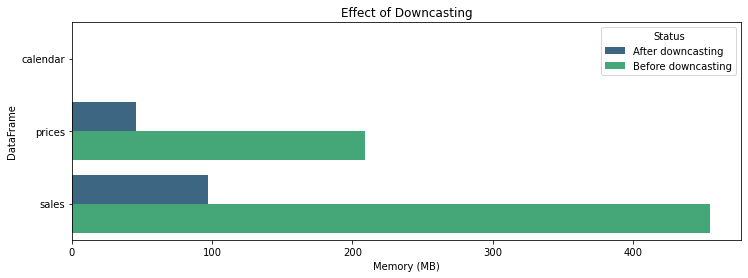

In [9]:
dic = {'DataFrame':['sales','calendar','prices'],
       'Before downcasting':[sales_train_bd,calendar_bd,prices_bd],
       'After downcasting':[sales_train_ad,calendar_ad,prices_ad]}

memory = pd.DataFrame(dic)
memory = pd.melt(memory, id_vars='DataFrame', var_name='Status', value_name='Memory (MB)')
memory.sort_values('Memory (MB)',inplace=True)
plt.figure(figsize=(12,4))
sns.barplot(y='DataFrame',x='Memory (MB)',data=memory,hue='Status',palette='viridis').set_title('Effect of Downcasting')

We can see the downcast method effectively reduced size of dataframes and saved storage.

* **Melting the data**

The sales_train data has 1900+ columns and each column among d_1-d_1969 represents the sales data on that day. I will first convert the wide format dataframe to long format. And then combine the sales_train data with calendar and price data, and merge them into one big table.

In [10]:
df = pd.melt(sales_train,id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],var_name='d',value_name='sold').dropna()

In [11]:
df = pd.merge(df,calendar,on='d',how='left')
df = pd.merge(df,prices,on=['store_id','item_id','wm_yr_wk'],how='left')

In [12]:
# add two columns that might be useful for EDA
df['week'] = df['date'].dt.weekofyear.astype(np.int16)
df['revenue'] = df['sell_price']*df['sold'].astype(np.float32)

In [13]:
del sales_train,calendar,prices
del memory
del sales_train_ad,calendar_ad,prices_ad,sales_train_bd,calendar_bd,prices_bd

gc.collect()

20

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60034810 entries, 0 to 60034809
Data columns (total 24 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            category      
 1   item_id       category      
 2   dept_id       category      
 3   cat_id        category      
 4   store_id      category      
 5   state_id      category      
 6   d             object        
 7   sold          int16         
 8   date          datetime64[ns]
 9   wm_yr_wk      int16         
 10  weekday       category      
 11  wday          int8          
 12  month         int8          
 13  year          int16         
 14  event_name_1  category      
 15  event_type_1  category      
 16  event_name_2  category      
 17  event_type_2  category      
 18  snap_CA       int8          
 19  snap_TX       int8          
 20  snap_WI       int8          
 21  sell_price    float16       
 22  week          int16         
 23  revenue       float32       
d

In [15]:
df.isnull().sum()

id                     0
item_id                0
dept_id                0
cat_id                 0
store_id               0
state_id               0
d                      0
sold                   0
date                   0
wm_yr_wk               0
weekday                0
wday                   0
month                  0
year                   0
event_name_1    55095430
event_type_1    55095430
event_name_2    59882360
event_type_2    59882360
snap_CA                0
snap_TX                0
snap_WI                0
sell_price      12299413
week                   0
revenue         12299413
dtype: int64

From the above, null values exist in price column and event columns. Missing value in event columns are ligit and can be handled via encoding. The missing values in price column can just be dropped. I will do it later after feature engineering is done.

# 3. Exploratory data analysis

Text(0.5, 1.0, 'Distribution of categories')

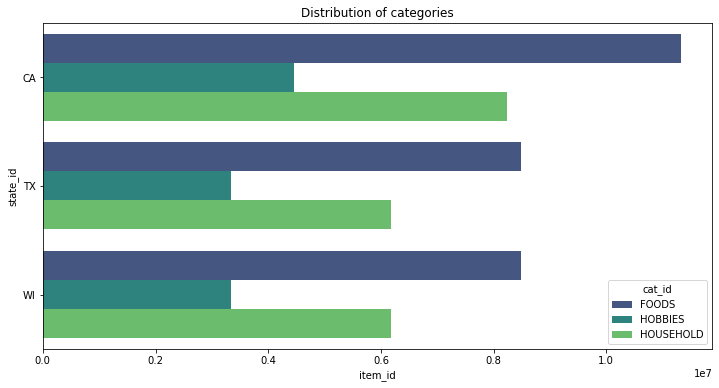

In [16]:
temp = df.groupby(['state_id','cat_id'],as_index=False)['item_id'].count().dropna()
plt.figure(figsize=(12,6))
sns.barplot(y='state_id',x='item_id',data=temp,hue='cat_id',palette='viridis').set_title('Distribution of categories')

From the above, Food category has the largest variety of items, and Hobbies category has the smallest variety of items.

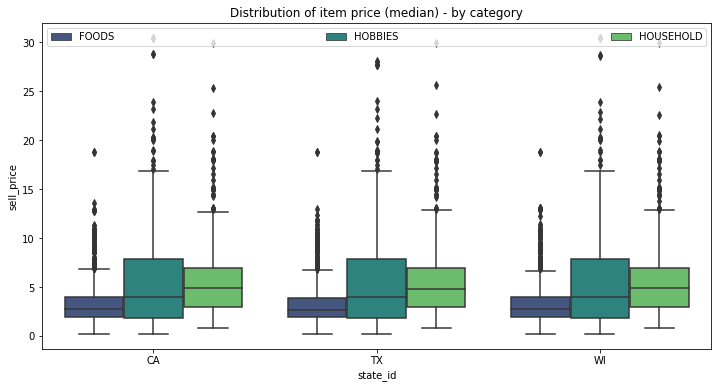

In [17]:
temp = df.groupby(['state_id','cat_id','item_id'],as_index=False)['sell_price'].mean().dropna()
plt.figure(figsize=(12,6))
sns.boxplot(x='state_id',y='sell_price',data=temp,hue='cat_id',palette='viridis').set_title('Distribution of item price (median) - by category')
plt.legend(loc='upper left',ncol=temp['cat_id'].nunique(),mode='expand')

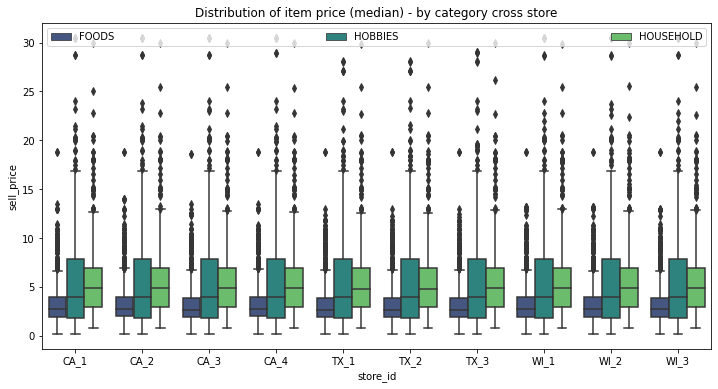

In [18]:
temp = df.groupby(['state_id','store_id','cat_id','item_id'],as_index=False)['sell_price'].mean().dropna()
plt.figure(figsize=(12,6))
sns.boxplot(x='store_id',y='sell_price',data=temp,hue='cat_id',palette='viridis').set_title('Distribution of item price (median) - by category cross store')
plt.legend(loc='upper left',ncol=temp['cat_id'].nunique(),mode='expand')

From the above, items under food category has relatively the lowest price and smallest price range. Items under Hobbies has the largest price range. Items under Household has highest average price and a smaller price range compared to Hobbies item.

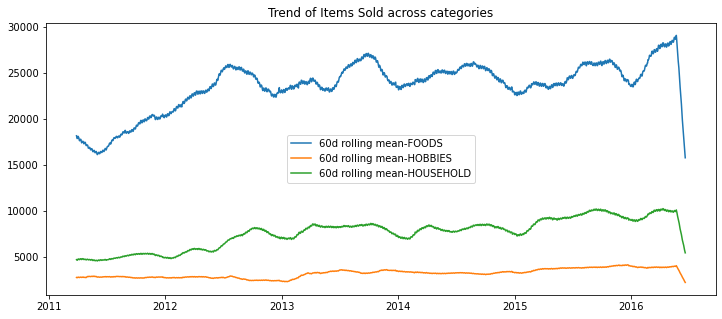

In [19]:
#temp = df.groupby(['date','state_id','store_id'],as_index=False)['sold'].sum().dropna()
temp = df.groupby(['date','d','cat_id'],as_index=False)['sold'].sum().dropna()
temp_pivot = temp.pivot(values='sold',columns='cat_id',index='date')
temp_pivot.head()

plt.figure(figsize=(12,5))
plt.plot(temp_pivot['FOODS'].rolling(window=60,center=False).mean(),label='60d rolling mean-FOODS')
plt.plot(temp_pivot['HOBBIES'].rolling(window=60,center=False).mean(),label='60d rolling mean-HOBBIES')
plt.plot(temp_pivot['HOUSEHOLD'].rolling(window=60,center=False).mean(),label='60d rolling mean-HOUSEHOLD')
plt.title('Trend of Items Sold across categories')
plt.legend()

From the above, the sales of Hobbies items increased at a very slow pace compared to foods and households.

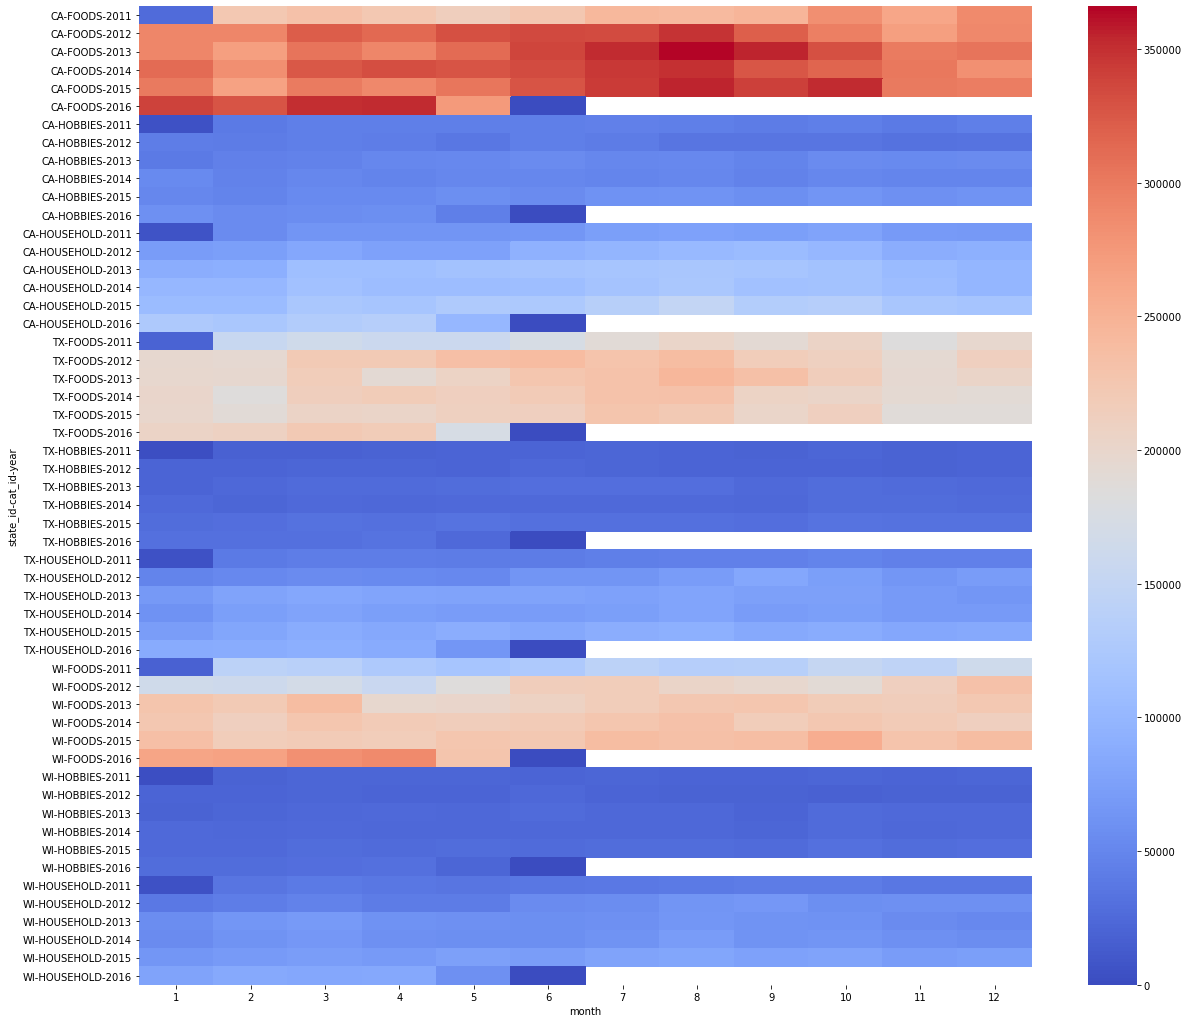

In [20]:
temp = df.pivot_table(columns='month',index=['state_id','cat_id','year'],values='sold',aggfunc=np.sum)
plt.figure(figsize=(20,18))
sns.heatmap(temp,cmap='coolwarm')

From the above, there is a very slight trend that the sales of all three categories are more popular in summer than in winter.

Text(0.5, 1.0, 'Distribution of item sales - cross stores')

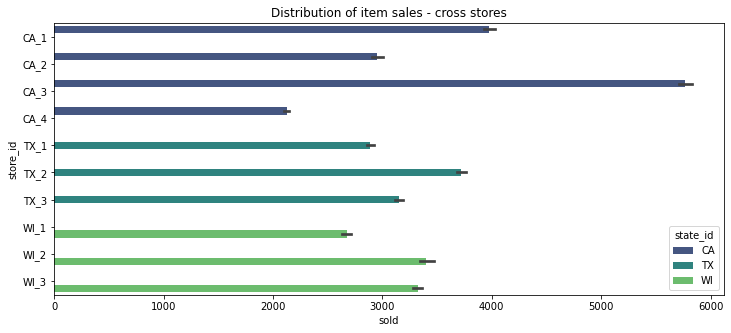

In [21]:
temp = df.groupby(['date','state_id','store_id'],as_index=False)['sold'].sum().dropna()
fig, ax = plt.subplots(figsize=(12,5))
sns.barplot(ax=ax,y='store_id',x='sold',data=temp,hue='state_id',palette='viridis').set_title('Distribution of item sales - cross stores')

From the above, store CA_3, TX_2 and WI_2 sell the most items in CA, TX and WI, respectively. 

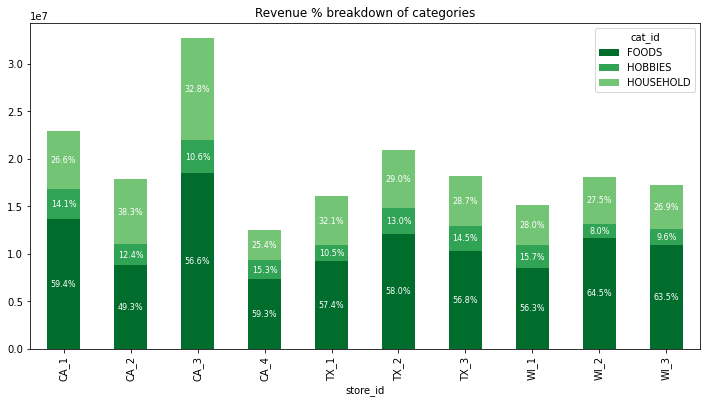

In [22]:
temp = df.groupby(['state_id','store_id','cat_id'],as_index=False)['revenue'].sum().dropna()
temp_pivot = pd.pivot_table(temp,values='revenue',columns='cat_id',index='store_id',margins=True,aggfunc='sum',).drop('All',0).reset_index()

total = temp_pivot['All']
temp_pivot = temp_pivot.iloc[:, 0:4]

colors = ['#006D2C','#31A354','#74C476']
temp_pivot.plot(x='store_id',kind='bar',stacked=True,title='Revenue % breakdown of categories',color=colors,mark_right=True,figsize=(12,6))

percent = temp_pivot[temp_pivot.columns[1:]].div(total, 0)*100
for n in percent:
    for i, (cs,col,pc,tot) in enumerate(zip(temp_pivot.iloc[:,1:].cumsum(1)[n],temp_pivot[n],percent[n],total)):
        #plt.text(tot, i, str(tot), va='center')
        plt.text(i,cs-col/2,str(np.round(pc,1))+'%',va='center',ha='center',fontsize=8,c='white')

From the above, store CA_3, TX_2 and WI_2 contributes the most revenue in CA, TX and WI, respectively. Also, food items generally contributes more than 50% revenue, while hobbies items generally contribute less than 15% revenue.

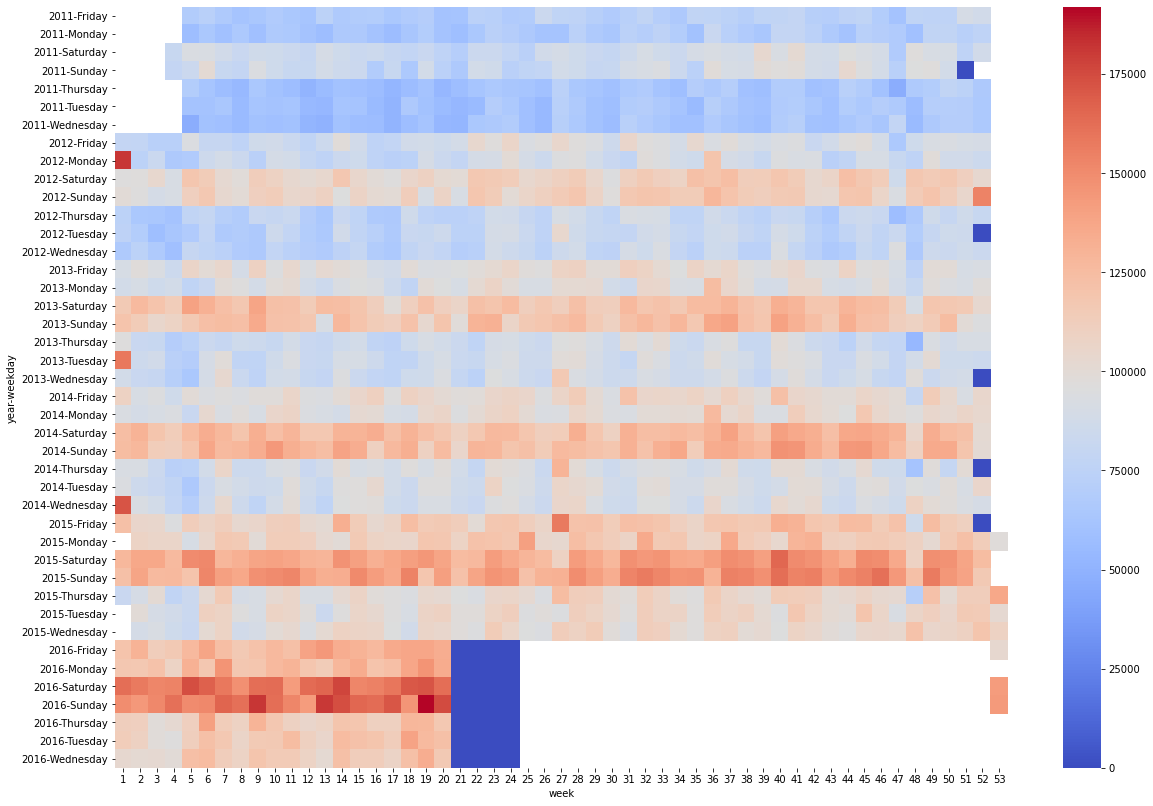

In [23]:
temp = df.pivot_table(columns='week',index=['year','weekday'],values='revenue',aggfunc=np.sum)
plt.figure(figsize=(20,14))
sns.heatmap(temp,cmap='coolwarm')

From the above, generally there is a spike in revenue over Saturdays and Sundays. Also there is a slight trend that on 48th and 52th weeks the overall revenue in Walmart drops, perhaps over the two big year-end holidays people tend to go to fancy stores for shopping other than Walmart. Or people are traveling around and need not go grocery shopping.

Also I noticed there are columns called snap_CA, snap_TX and snap_WI. What's SNAP? SNAP is a nutrition assistance benefit provided by US federal government. It provides low income families and individuals with an Electronic Benefits Transfer debit card to purchase food products. In many states, the monetary benefits are dispersed to people across 10 days of the month and on each of these days 1/10 of the people will receive the benefit on their card.

Back to the 'snap' columns in the dataframe, value 1 means it's a SNAP day and value 0 means it's a non-SNAP day. Next I will explore how sales change among SNAP and non-SNAP days.

In [24]:
def plot_break(df):
    idx = pd.date_range(df.date.dt.date.min(),df.date.dt.date.max())
    df = df.set_index('date')
    df = df.reindex(idx)
    df.reset_index(inplace=True)
    df.rename(columns={'index':'date'},inplace=True)
    return df

def plot_snap(df,state,metric):
    total = df[df['state_id']==state]
    food_total = total[total['cat_id']=='FOODS']
    
    total = total.groupby(['date','snap_'+state],as_index=False)['sold','revenue'].sum()
    total_snap = total[total['snap_'+state]==1]
    total_non_snap = total[total['snap_'+state]==0]
    food_total = food_total.groupby(['date','snap_'+state],as_index=False)['sold','revenue'].sum()
    food_snap = food_total[food_total['snap_'+state]==1]
    food_non_snap = food_total[food_total['snap_'+state]==0]
    
    total_snap = plot_break(total_snap)
    total_non_snap = plot_break(total_non_snap)
    food_snap = plot_break(food_snap)
    food_non_snap = plot_break(food_non_snap)
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=total_non_snap['date'],y=total_non_snap[metric],name='Total '+metric+'(Non-SNAP)'))
    fig.add_trace(go.Scatter(x=total_snap['date'],y=total_snap[metric],name='Total '+metric+'(SNAP)'))
    fig.add_trace(go.Scatter(x=food_non_snap['date'],y=food_non_snap[metric],name='Food '+metric+'(Non-SNAP)'))
    fig.add_trace(go.Scatter(x=food_snap['date'],y=food_snap[metric],name='Food '+metric+'(SNAP)'))
    fig.update_yaxes(title_text='Total items sold' if metric=='sold' else 'Total revenue($)')
    fig.update_layout(template='seaborn',title=state)
    fig.update_layout(legend=dict(
                    orientation="h",
                    yanchor="bottom",
                    y=1.02,
                    xanchor="right",
                    x=1
                    ))
    
    return fig

In [25]:
fig1 = plot_snap(df,'CA','sold')
fig1.show()
fig2 = plot_snap(df,'CA','revenue')
fig2.show()

From the above, I ran the same for TX and WI, basically on SNAP days both sales and revenues are higher than those on non-SNAP days. 

In [26]:
del temp, temp_pivot
gc.collect()

6431

# 4. Feature engineering

* **Label encoding**

In [27]:
#Store the categories along with their codes
df_id = dict(zip(df.id.cat.codes,df.id))
df_store_id = dict(zip(df.store_id.cat.codes,df.store_id))
#df_item_id = dict(zip(df.item_id.cat.codes,df.item_id))
#df_dept_id = dict(zip(df.dept_id.cat.codes,df.dept_id))
#df_cat_id = dict(zip(df.cat_id.cat.codes,df.cat_id))
#df_state_id = dict(zip(df.state_id.cat.codes,df.state_id))

In [28]:
# transform column 'd' so it can be stored as int type
df.d = df['d'].apply(lambda x: x.split('_')[1]).astype(np.int16)
# encode the categorical columns
cols = df.dtypes.index.tolist()
types = df.dtypes.values.tolist()
for i,t in enumerate(types):
    if t.name == 'category':
        df[cols[i]] = df[cols[i]].cat.codes        

In [29]:
# drop column 'date' as this information has been present in column 'd'
df.drop(['date'],axis=1,inplace=True)

* **Lagged features**

In [30]:
lags = [1,3,7,14,28]
for lag in lags:
    col = ('sold_lag_%s' % lag)
    df[col] = df.groupby(['id','item_id','dept_id','cat_id','store_id','state_id'],as_index=False)['sold'].shift(lag).astype(np.float16)

* **Rolling and expanding statistics**

In [31]:
# rolling stats with window=7 and 28
func_roll_7 = lambda x: x.rolling(window=7).mean()
func_roll_28 = lambda x: x.rolling(window=28).mean()
df['sold_rolling7_mean'] = df.groupby(['id', 'item_id','dept_id','cat_id','store_id','state_id'])['sold'].apply(func_roll_7).astype(np.float16)
df['sold_rolling28_mean'] = df.groupby(['id', 'item_id','dept_id','cat_id','store_id','state_id'])['sold'].apply(func_roll_28).astype(np.float16)
df['revenue_rolling7_mean'] = df.groupby(['id', 'item_id','dept_id','cat_id','store_id','state_id'])['revenue'].apply(func_roll_7).astype(np.float16)

In [32]:
# expanding stats
func_exp = lambda x: x.expanding(2).mean()
df['sold_expanding_mean'] = df.groupby(['id', 'item_id','dept_id','cat_id','store_id','state_id'])['sold'].apply(func_exp).astype(np.float16)

* **Trending stats**

For now I will be skipping the trending features due to limited memory.

In [33]:
# the trending stat will have a positive value if the daily items sold are greater than the entire duration average ( d_1 - d_1969 ), otherwise it will have a negative value
#df['sold_daily_avg'] = df.groupby(['d','id', 'item_id','dept_id','cat_id','store_id','state_id'])['sold'].mean().astype(np.float16)
#df['sold_avg'] = df.groupby(['id', 'item_id','dept_id','cat_id','store_id','state_id'])['sold'].mean().astype(np.float16)
#df['sold_trend'] = (df['sold_daily_avg']-df['sold_avg']).astype(np.float16)
#df.drop(['sold_daily_avg','sold_avg'],axis=1,inplace=True)

* **Mean encoding**

From a mathematical point of view, mean encoding represents a probability of your target variable, conditional on each value of the feature. In a way, it embodies the target variable in its encoded value. For example, we can take average sales by combining different categorical features:

In [34]:
#item
# df['sold_mean_item'] = df.groupby('item_id')['sold'].mean().astype(np.float16)
#category & department
# df['sold_mean_cat_dept'] = df.groupby(['cat_id','dept_id'])['sold'].mean().astype(np.float16)
#state, store and category
# df['sold_mean_state_store_cat'] = df.groupby(['state_id','store_id','cat_id'])['sold'].mean().astype(np.float16)

However one downside with mean encoding is that it may cause data leakage as these average values contain information from both train set and validation set. For now I will skip the mean encoding features.

In [35]:
# after creating lagged features and calculating mean values, now I will get rid of the first 28 days' data to avoid null values
df = df[df['d']>=28]
df.dropna(inplace=True)

In [36]:
print('\ndf shape: ',df.shape)
print('\ndf null values: ',df.isnull().sum())


df shape:  (47291676, 32)

df null values:  id                       0
item_id                  0
dept_id                  0
cat_id                   0
store_id                 0
state_id                 0
d                        0
sold                     0
wm_yr_wk                 0
weekday                  0
wday                     0
month                    0
year                     0
event_name_1             0
event_type_1             0
event_name_2             0
event_type_2             0
snap_CA                  0
snap_TX                  0
snap_WI                  0
sell_price               0
week                     0
revenue                  0
sold_lag_1               0
sold_lag_3               0
sold_lag_7               0
sold_lag_14              0
sold_lag_28              0
sold_rolling7_mean       0
sold_rolling28_mean      0
revenue_rolling7_mean    0
sold_expanding_mean      0
dtype: int64


# 5. Model fit and prediction

In [37]:
df.head().T

,853727,853728,853729,853731,853734
id,14440.000000,14450.000000,14460.000000,14480.000000,14510.000000
item_id,1444.000000,1445.000000,1446.000000,1448.000000,1451.000000
dept_id,3.000000,3.000000,3.000000,3.000000,3.000000
cat_id,1.000000,1.000000,1.000000,1.000000,1.000000
store_id,0.000000,0.000000,0.000000,0.000000,0.000000
state_id,0.000000,0.000000,0.000000,0.000000,0.000000
d,29.000000,29.000000,29.000000,29.000000,29.000000
sold,0.000000,8.000000,0.000000,1.000000,16.000000
wm_yr_wk,11105.000000,11105.000000,11105.000000,11105.000000,11105.000000
weekday,2.000000,2.000000,2.000000,2.000000,2.000000


Since the goal is to predict item sales at stores in various locations for two 28-day time periods, in other words the output will be (N store * 28 day) dimension, I will do train/test data split for each store respectively, then make prediction/evaluation separately.

In [38]:
# split the data: there are 1969 dates in the sales_validation file, I will use:
# d1-d1913: 1913 days as train
# d1914-1941: 28 days as validation
# d1942-1969: 28 days as test
valid = df[(df['d']>=1914)&(df['d']<1942)][['id','d','sold']]
test = df[df['d']>=1942][['id','d','sold']]
y_pred_val = valid['sold']
y_pred_test = test['sold']

Why LightGBM? In the last time series project, I used XGBoost. LightGBM improves on XGBoost. In a LightGBM paper ([paper link here](https://papers.nips.cc/paper/6907-lightgbm-a-highly-efficient-gradient-boosting-decision-tree)), it uses XGBoost as a baseline and outperforms it in training speed and the dataset sizes it can handle. In this project I will try to play with LightGBM and see how it works.

In [39]:
from lightgbm import LGBMRegressor
import joblib

stores = df['store_id'].unique().tolist()
for store in stores:
    df_sub = df[df['store_id']==store]
    
    X_train,y_train = df_sub[df_sub['d']<1914].drop('sold',axis=1),df_sub[df_sub['d']<1914]['sold']
    X_valid,y_valid = df_sub[(df_sub['d']>=1914)&(df_sub['d']<1942)].drop('sold',axis=1),df_sub[(df_sub['d']>=1914)&(df_sub['d']<1942)]['sold']
    X_test = df_sub[df_sub['d']>=1942].drop('sold',axis=1)
    
    model = LGBMRegressor(n_estimators=1000,
                          learning_rate=0.3,
                          subsample=0.8,
                          colsample_bytree=0.8,
                          max_depth=8,
                          num_leaves=50,
                          #objective='poisson',
                          min_child_weight=300)
    
    print('##### Prediction for store: {} #####'.format(df_store_id[store]))
    model.fit(X_train,y_train,
              eval_set=[(X_train,y_train),(X_valid,y_valid)],
              eval_metric='rmse',
              verbose=20,
              early_stopping_rounds=20)
    y_pred_val[X_valid.index] = model.predict(X_valid)
    y_pred_test[X_test.index] = model.predict(X_test)
    
    filename = 'model'+str(df_store_id[store])+'.pkl'
    # save model 
    joblib.dump(model,filename)
    del model,X_train,y_train,X_valid,y_valid
    gc.collect()

##### Prediction for store: CA_1 #####
Training until validation scores don't improve for 20 rounds
[20]	training's rmse: 0.768533	training's l2: 0.590643	valid_1's rmse: 0.466285	valid_1's l2: 0.217422
[40]	training's rmse: 0.716731	training's l2: 0.513703	valid_1's rmse: 0.434251	valid_1's l2: 0.188574
[60]	training's rmse: 0.696011	training's l2: 0.484432	valid_1's rmse: 0.424996	valid_1's l2: 0.180622
[80]	training's rmse: 0.682152	training's l2: 0.465332	valid_1's rmse: 0.425655	valid_1's l2: 0.181182
[100]	training's rmse: 0.674915	training's l2: 0.45551	valid_1's rmse: 0.423065	valid_1's l2: 0.178984
[120]	training's rmse: 0.660533	training's l2: 0.436304	valid_1's rmse: 0.422507	valid_1's l2: 0.178513
Early stopping, best iteration is:
[110]	training's rmse: 0.666612	training's l2: 0.444372	valid_1's rmse: 0.420469	valid_1's l2: 0.176794
##### Prediction for store: CA_2 #####
Training until validation scores don't improve for 20 rounds
[20]	training's rmse: 0.37601	training's l

In [40]:
print(y_pred_val.head())
print(df[(df['d']>=1914)&(df['d']<1942)]['sold'].head())

58327370   -0.045291
58327371   -0.005528
58327372   -0.008805
58327373   -0.056375
58327374    1.002163
Name: sold, dtype: float64
58327370    0
58327371    0
58327372    0
58327373    0
58327374    1
Name: sold, dtype: int16


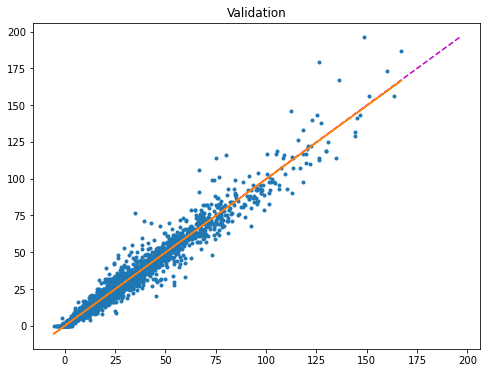

In [41]:
# define a performance evaluation function and visualize the performance of the model
# The closer the points are to the middle dashed line the better are the predictions.
from numpy.polynomial.polynomial import polyfit

def model_performance_sc_plot(predictions,labels,title):
    min_val = max(max(predictions),max(labels))
    max_val = min(min(predictions),min(labels))
    performance = pd.DataFrame({'Label':labels,'Prediction':predictions})
    
    b, m = polyfit(performance['Prediction'], performance['Label'], 1)
    # plot the data
    plt.figure(figsize=(8,6))
    plt.plot([min_val,max_val],[min_val,max_val],'m--')
    plt.plot(performance['Prediction'],performance['Label'],'.')
    plt.plot(performance['Prediction'],b+m*performance['Prediction'],'-')
    plt.title(title)

model_performance_sc_plot(y_pred_val,df[(df['d']>=1914)&(df['d']<1942)]['sold'],'Validation')

From the above, we can see that data points  are almost evenly distributed along the dashed line, which proves that LightGBM model can also provide top accuracy.

In [42]:
import os

feat_importance = pd.DataFrame()
features = [f for f in df.columns if f != 'sold']
for file in os.listdir('/kaggle/working'):
    if 'model' in file:
        # load model
        model = joblib.load(file)
        store = pd.DataFrame()
        store['feature'] = features
        store['importance'] = model.feature_importances_
        store['store'] = file[5:9]
        feat_importance =  pd.concat([feat_importance,store],axis=0)

feat_importance.T

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
feature,id,item_id,dept_id,cat_id,store_id,state_id,d,wm_yr_wk,weekday,wday,...,revenue,sold_lag_1,sold_lag_3,sold_lag_7,sold_lag_14,sold_lag_28,sold_rolling7_mean,sold_rolling28_mean,revenue_rolling7_mean,sold_expanding_mean
importance,39,3,0,0,0,0,16,16,11,68,...,1297,456,394,197,102,212,1209,281,461,106
store,TX_1,TX_1,TX_1,TX_1,TX_1,TX_1,TX_1,TX_1,TX_1,TX_1,...,WI_2,WI_2,WI_2,WI_2,WI_2,WI_2,WI_2,WI_2,WI_2,WI_2


Text(0.5, 1.0, 'LightGBM Feature Importance (average across stores)')

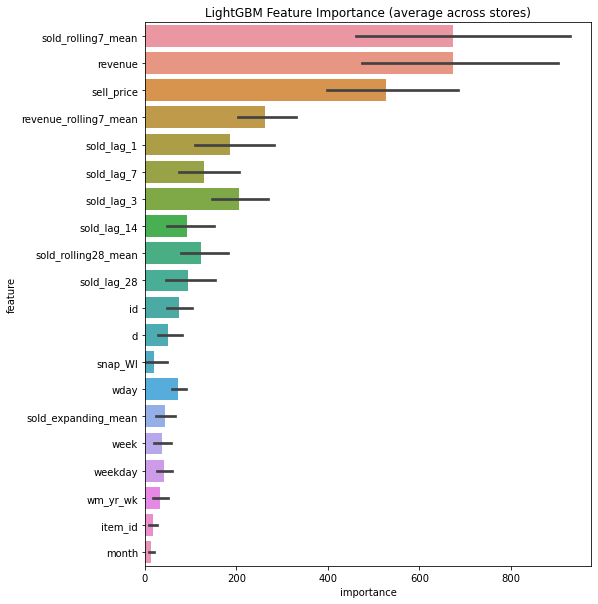

In [43]:
cols = feat_importance[['feature','importance']].groupby('feature').mean().sort_values(by='importance',ascending=False)[:20].index
best_feat = feat_importance.loc[feat_importance['feature'].isin(cols)]

plt.figure(figsize=(8,10))
sns.barplot(x='importance',y='feature',data=best_feat.sort_values(by='importance',ascending=False))
plt.title('LightGBM Feature Importance (average across stores)')

**Generate submission file**

In [44]:
#Get the actual validation results
valid['sold'] = y_pred_val
validation = valid[['id','d','sold']]
validation = pd.pivot(validation, index='id', columns='d', values='sold').reset_index()
validation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]
validation.id = validation.id.map(df_id).str.replace('evaluation','validation')

#Get the evaluation results
test['sold'] = y_pred_test
evaluation = test[['id','d','sold']]
evaluation = pd.pivot(evaluation, index='id', columns='d', values='sold').reset_index()
evaluation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]
#Remap the category id to their respective categories
evaluation.id = evaluation.id.map(df_id)

#Prepare the submission
submit = pd.concat([validation,evaluation]).reset_index(drop=True)
submit.to_csv('submission.csv',index=False)